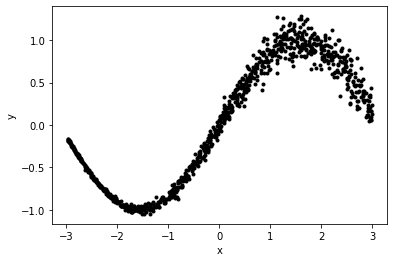

'ToyDataset' object created!
x: (1000,)
y: (1000,)

'ToyDatasetEval' object created!
x: (1000,)



In [1]:
# ========== #
#  Datasets  #
# ========== #

# Libraries
import torch
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import numpy as np

import matplotlib
# matplotlib.use('Agg')  # I needed to disable it when running on Jupyter
import matplotlib.pyplot as plt

import pickle

class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, showPlot=False):
        self.examples = []

        with open("/home/nicolas/Downloads/bnn/evaluating_bdl/toyRegression/x.pkl", "rb") as file:  # (needed for python3)
            x = pickle.load(file)

        with open("/home/nicolas/Downloads/bnn/evaluating_bdl/toyRegression/y.pkl", "rb") as file:  # (needed for python3)
            y = pickle.load(file)
    
        if showPlot:
            plt.figure(1)
            plt.plot(x, y, "k.")
            plt.ylabel("y")
            plt.xlabel("x")
            plt.savefig("/home/nicolas/Downloads/bnn/evaluating_bdl/toyRegression/MC-Dropout-MAP-02-Adam/training_data.png")
            plt.show()
            # plt.close(1) # I needed to disable it when running on Jupyter
        
        for i in range(x.shape[0]):
            example = {}
            example["x"] = x[i]
            example["y"] = y[i]
            self.examples.append(example)

        self.num_examples = len(self.examples)

        print("'ToyDataset' object created!")
        print("x:", x.shape)
        print("y:", y.shape)
        print()

    def __getitem__(self, index):
        example = self.examples[index]
        
        x = example["x"]
        y = example["y"]

        return (x, y)

    def __len__(self):
        return self.num_examples

class ToyDatasetEval(torch.utils.data.Dataset):
    def __init__(self, showPlot=False):
        self.examples = []

        x = np.linspace(-7, 7, 1000, dtype=np.float32)

        for i in range(x.shape[0]):
            example = {}
            example["x"] = x[i]
            self.examples.append(example)

        self.num_examples = len(self.examples)

        print("'ToyDatasetEval' object created!")
        print("x:", x.shape)
        print()


    def __getitem__(self, index):
        example = self.examples[index]

        x = example["x"]

        return (x)

    def __len__(self):
        return self.num_examples

data = ToyDataset(showPlot=True)
data_eval = ToyDatasetEval()

# print(data[0])  # Test __getitem__
# print(len(data))  # Test __len__

# print(data_eval[0])  # Test __getitem__
# print(len(data_eval))  # Test __len__


In [2]:
# ======= #
#  Model  #
# ======= #

# Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

import os

class ToyNet(nn.Module):
    def __init__(self, model_id, project_dir):
        # super(ToyNet, self).__init__()  # Python2
        super().__init__()  # Python3

        self.model_id = model_id
        self.project_dir = project_dir
        self.create_model_dirs()

        # Network Params
        input_dim = 1
        hidden_dim = 10
        output_dim = 1

        # Applies a linear transformation to the incoming data: y = x.A^T + b (Learnable Weights & bias)
        # Networks 1 - Predicts the mean
        self.fc1_mean = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_mean = nn.Linear(hidden_dim, output_dim)

        # Network 2 - Predicts the Variance
        self.fc1_var = nn.Linear(input_dim, hidden_dim)
        self.fc2_var = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_var = nn.Linear(hidden_dim, output_dim)

        print("'ToyNet' object created!")

    def forward(self, x):
        # (x has shape: (batch_size, input_dim))

        # Networks 1 - Predicts the mean
        mean = F.relu(self.fc1_mean(x))                 # (shape: (batch_size, hidden_dim))
        mean = F.dropout(mean, p=0.2, training=True)    
        mean = F.relu(self.fc2_mean(mean))              # (shape: (batch_size, hidden_dim))
        mean = self.fc3_mean(mean)                      # (shape: (batch_size, output_dim))

        # Network 2 - Predicts the Variance
        var = F.relu(self.fc1_var(x))                   # (shape: (batch_size, hidden_dim))
        var = F.dropout(var, p=0.2, training=True)    
        var = F.relu(self.fc2_var(var))                 # (shape: (batch_size, hidden_dim))
        var = self.fc3_var(var)                         # (shape: (batch_size, output_dim))

        return (mean, var)

    def create_model_dirs(self):
        self.logs_dir = self.project_dir + "/training_logs"
        self.model_dir = self.logs_dir + "/model_%s" % self.model_id
        self.checkpoints_dir = self.model_dir + "/checkpoints"
        if not os.path.exists(self.logs_dir):
            os.makedirs(self.logs_dir)
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
            os.makedirs(self.checkpoints_dir)

## Train

For ensembling and MC-dropout, we minimize the MAP objective $-\text{log}\ p(Y|X, \theta).p(\theta)$. In our case where the model parameters $\theta \in \mathbb{R}^P$ and $p(\theta)=\mathcal{N}(0, I_P)$, this corresponds to the following loss for regression: 

$$ \underbrace{L(\theta)}_{\mathcal{L}_{total}} = \underbrace{\frac{1}{N}\sum_{i=1}^{N} \frac{(y_i - \hat{\mu}(x_i))^2}{\hat{\sigma}^2(x_i)} + \text{log}\ \hat{\sigma}^2(x_i)}_{\mathcal{L}_{ Likelihood}} + \underbrace{\frac{1}{N}\theta^T\theta}_{\mathcal{L}_{Prior}}$$

The implemented equation on the code has two new parameters: `alpha=1.0` (?) and `p=0.2` (Dropout Rate)

$$ \underbrace{L(\theta)}_{\mathcal{L}_{total}} = \underbrace{\frac{1}{N}\sum_{i=1}^{N} \frac{(y_i - \hat{\mu}(x_i))^2}{\hat{\sigma}^2(x_i)} + \text{log}\ \hat{\sigma}^2(x_i)}_{\mathcal{L}_{ Likelihood}} + \underbrace{\frac{1-p}{N}\frac{1}{\alpha}\sum_{i=1}^{P}\theta_i}_{\mathcal{L}_{Prior}}$$


In [3]:
# ======= #
#  Train  #
# ======= #

# Libraries
# from datasets import ToyDataset # (this needs to be imported before torch, because cv2 needs to be imported before torch for some reason)
# from model import ToyNet

import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pickle
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as pyplot
import cv2
import time

# NOTE! Change this to not overwrite all log data when you train the model:
model_id = "MC-Dropout-MAP-02-Adam_1_M10"

# Training Params
num_epochs = 300
batch_size = 2
learning_rate = 0.001

train_dataset = ToyDataset()
N = float(len(train_dataset))

num_train_batches = int(len(train_dataset)/batch_size)
print ("num_train_batches: {}\n".format(num_train_batches))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Loss Params
alpha = 1.0
p = 0.2

M = 10
for i in range(M):
    network = ToyNet(model_id + "_%d" % i, project_dir="/home/nicolas/Downloads/bnn/evaluating_bdl/toyRegression").cuda()

    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    epoch_losses_train = []
    for epoch in range(num_epochs):
        # print ("###########################")
        # print ("######## NEW EPOCH ########")
        # print ("###########################")
        # print ("epoch: %d/%d" % (epoch+1, num_epochs))
        # print ("network: %d/%d" % (i+1, M))
        print ("M: %d/%d, epoch: %d/%d" % (i+1, M, epoch+1, num_epochs))
        
        network.train()  # TODO: move to below network declaration?
        batch_losses = []
        for step, (x, y) in enumerate(train_loader):
            # Convert to Cuda Tensor and add dimension, [batch_size] -> [batch_size, 1]
            x = Variable(x).cuda().unsqueeze(1)  # (shape: (batch_size, 1)), [2, 1] 
            y = Variable(y).cuda().unsqueeze(1)  # (shape: (batch_size, 1)), [2, 1]

            # Predict
            outputs = network(x)
            mean = outputs[0]     # (shape: (batch_size, ))
            log_var = outputs[1]  # (shape: (batch_size, )), log(sigma^2)

            # Compute the loss
            loss_likelihood = torch.mean(torch.exp(-log_var)*torch.pow(y - mean, 2) + log_var)

            loss_prior = 0.0
            for param in network.parameters():
                if param.requires_grad:
                    loss_prior += ((1.0 - p)/N)*(1.0/alpha)*torch.sum(torch.pow(param, 2))

            loss = loss_likelihood + loss_prior
            loss_value = loss.data.cpu().numpy()  # batch_loss

            batch_losses.append(loss_value)

            # Optimization Step
            optimizer.zero_grad()  # (reset gradients)
            loss.backward()        # (compute gradients)
            optimizer.step()       # (perform optimization step)
    
        epoch_loss = np.mean(batch_losses)
        epoch_losses_train.append(epoch_loss)

        with open("%s/epoch_losses_train.pkl" % network.model_dir, "wb") as file:
            pickle.dump(epoch_losses_train, file)

        print ("train loss: %g" % epoch_loss)


'ToyDataset' object created!
x: (1000,)
y: (1000,)

num_train_batches: 500

'ToyNet' object created!
M: 1/10, epoch: 1/300
train loss: 0.506736
M: 1/10, epoch: 2/300
